# SB - ShearSplink comparison

This Jupyter notebook reproduces the panels from Figure 4, in which we compare insertions and CTGs identified in the SB dataset using IM-Fusion with results from ShearSplink sequencing, a DNA-sequencing based approach to identifying insertions. For IM-Fusion, we use the same dataset as used for the SB analysis. The ShearSplink insertions were identified using a pipeline from *PyIM*, which was run separately from this notebook using a Snakemake pipeline.

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

/home/NFS/users/j.d.ruiter/.anaconda3/envs/imfusion/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/NFS/users/j.d.ruiter/.anaconda3/envs/imfusion/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Datasets

First, we load the two datasets, dropping any insertions that are supported by less than two reads. To ensure the datasets use the same sample names, we map the (shorter) ShearSplink sample names to the RNA-seq ids of the corresponding samples:

In [2]:
# Read samples.
samples = pd.read_csv('../data/processed/sb/samples.txt', sep='\t')

# Read IM-Fusion insertions, selecting only insertions that are supported
# by at least two reads (as we did for the CTG test).
insertions_rna = (pd.read_csv('../data/processed/sb/star/insertions.txt',
                              dtype={'seqname': str}, sep='\t')
                    .query('support >= 2'))

# Read ShearSplink insertions.
insertions_dna = (pd.read_csv('../data/external/shear_splink/insertions.rbm.txt', 
                              dtype={'chromosome': str, 
                                     'position': int,
                                     'strand': int, 
                                     'support': int,
                                     'depth': int,
                                     'depth_unique': int}, sep='\t')
                    .rename(columns={'chromosome': 'seqname'})
                    .query('support >= 2'))

name_map = dict(zip(samples['short_name'], samples['sample']))
insertions_dna['sample'] = insertions_dna['sample'].map(name_map)

# Add clonality score.
insertions_dna['clonality'] = (insertions_dna.groupby(['sample'])
                               ['support'].transform(lambda x: x / x.max()))

In [3]:
insertions_dna.head()

,id,seqname,position,strand,support,depth,depth_unique,gene_distance,gene_id,gene_name,gene_orientation,sample,window,clonality
0,11KOU012-R3.INS_1,5,123894031,1,22,30,22,-13144.0,ENSMUSG00000023106,Denr,sense,1566_6_11KOU012-R3,ds,1.0
1,11KOU012-R3.INS_10,6,61597362,-1,11,14,11,0.0,ENSMUSG00000039578,Ccser1,antisense,1566_6_11KOU012-R3,ia,0.5
2,11KOU012-R3.INS_11,2,60112691,1,11,16,11,0.0,ENSMUSG00000026987,Baz2b,antisense,1566_6_11KOU012-R3,ia,0.5
3,11KOU012-R3.INS_12,4,126700075,1,11,13,11,0.0,ENSMUSG00000028837,Psmb2,sense,1566_6_11KOU012-R3,is,0.5
4,11KOU012-R3.INS_13,5,118658346,1,11,16,11,0.0,ENSMUSG00000018076,Med13l,sense,1566_6_11KOU012-R3,is,0.5


## Comparing insertions

### Matching insertions

To determine which insertions are shared between the two datasets, we match insertions in the IM-Fusion set to compatible insertions from ShearSplink using the match_rnaseq_insertions function. This function essentially matches two insertions if they are in the same sample, have the same target gene and have compatible locations. 

We then annotate these matches with different statistics (i.e. support in IM-Fusion, support in ShearSplink, distance to target gene), which we will later on when identifying biases of either approach. Finally, we assign a 'type' to each match, which labels insertions as being 'Shared', 'ShearSplink-specific' or 'IM-Fusion-specific'.

In [4]:
from imfusion.expression import normalize_counts
from nbsupport import match, util
    
# Match RNA to DNA insertions.
matches = match.match_rnaseq_insertions(
    insertions_rna, insertions_dna, keep_unmatched=True)

# Drop matches without gene and matches for novel transcripts.
matches = matches.ix[~(matches['gene_id'].isnull() | 
                       matches['gene_id'].str.startswith('STRG'))]

# Annotate matches.
gtf_path = '../data/external/ensembl/Mus_musculus.GRCm38.76.gtf.gz'
genes = util.read_gtf_genes(gtf_path).set_index('id')

expr = (pd.read_csv('../data/processed/sb/star/expression.fc_gene.txt', 
                           sep='\t', comment='#')
          .drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1)
          .rename(columns={'Geneid': 'gene_id'})
          .set_index('gene_id')
          .rename(columns=lambda c: c.split('/')[-2])
          .pipe(normalize_counts)
          .pipe(lambda df: np.log2(df + 1)))

matches = (
    matches.pipe(match.annotate_rna_info, rna_insertions=insertions_rna)
           .pipe(match.annotate_dna_info, dna_insertions=insertions_dna)
           .pipe(match.annotate_dna_gene_distance, genes=genes)
           .pipe(match.annotate_dna_gene_position, genes=genes)
           .pipe(match.annotate_expression, expr=expr)
           .pipe(match.annotate_type))

# Map types to more readable labels.
matches['type'] = matches['type'].map({
    'shared': 'Shared',
    'dna-only': 'ShearSplink-specific',
    'rna-only': 'IM-Fusion-specific'
})

matches.head()

,rna_id,dna_id,sample,gene_id,rna_position,rna_support,dna_position,dna_support,dna_clonality,gene_distance,dna_gene_position,expr,type
0,1566_10_11KOU023.INS_14,11KOU023.INS_4,1566_10_11KOU023,ENSMUSG00000038679,50822104.0,31.0,50798595.0,46.0,0.541176,0.0,0.389747,12.526379,Shared
1,1566_10_11KOU023.INS_14,11KOU023.INS_1,1566_10_11KOU023,ENSMUSG00000038679,50822104.0,31.0,50807519.0,85.0,1.000000,0.0,0.351887,12.526379,Shared
2,1566_10_11KOU023.INS_10,11KOU023.INS_3,1566_10_11KOU023,ENSMUSG00000019907,108240180.0,9.0,108240765.0,48.0,0.564706,0.0,0.680402,9.932479,Shared
3,1566_10_11KOU023.INS_18,11KOU023.INS_12,1566_10_11KOU023,ENSMUSG00000035168,59646873.0,3.0,59687915.0,21.0,0.247059,0.0,0.324098,9.991216,Shared
4,1566_10_11KOU023.INS_5,11KOU023.INS_8,1566_10_11KOU023,ENSMUSG00000022961,91664823.0,2.0,91665867.0,27.0,0.317647,0.0,0.578951,12.058172,Shared


We can then plot the overlap between the two sets as a venn diagram:

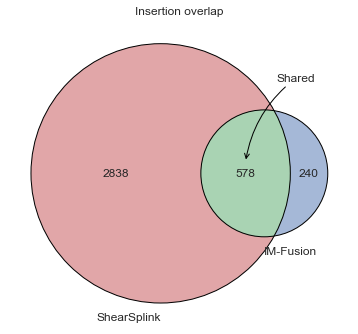

In [5]:
match.plot_insertion_overlap(matches)

# Plot for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2, 2))
    venn = match.plot_insertion_overlap(
        matches,  fontsize=5, label_offset=(25, 25),
        line_width=0.5, ax=ax)
    fig.savefig('../reports/figures/fig_4a_venn.pdf', bbox_inches='tight')
    plt.close(fig)

### Biases

To determine why certain insertions are unique to IM-Fusion or ShearSplink, we train a logistic regression model on the different features of the matches to predict whether an insertion is matched or not. We use the trained model to determine if a given feature has a significant effect.

#### ShearSplink-specific insertions

For the ShearSplink-specific insertions we train a model using different DNA-sequencing based features (such as dna_support, gene_distance and dna_gene_position) and the expression of the corresponding gene. As a negative 'control', we include a random feature which should not be significant in our analysis.

In [6]:
from statsmodels.formula.api import logit

# Subset for Shared/DNA-specific matches.
dna_matches = matches.ix[matches.type != 'IM-Fusion-specific']

# Create data for GLM.
data = dna_matches[['dna_support', 'gene_distance', 'type', 'expr', 'dna_gene_position']].copy()
data['dna_gene_position'] = data['dna_gene_position']
data['random'] = np.random.uniform(size=data.shape[0])
data['type'] = data['type'].map({'Shared': 1, 'ShearSplink-specific': 0})

# Fit model with gene distance.
model = logit('type ~ dna_support + gene_distance + expr + random', data)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.317568
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                 3416
Model:                          Logit   Df Residuals:                     3411
Method:                           MLE   Df Model:                            4
Date:                Tue, 25 Apr 2017   Pseudo R-squ.:                  0.3015
Time:                        10:42:07   Log-Likelihood:                -1084.8
converged:                       True   LL-Null:                       -1553.0
                                        LLR p-value:                2.221e-201
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -7.6258      0.372    -20.526      0.000      -8.354      -6.898
dna_support       0.

From the above results, we see that each of the features a significant effect, except for the random feature (which was our 'negative control'). Besides this model, we train an additional model including the dna_gene_position feature (describing the relative position of an insertion within the gene), which was previously ommitted as this feature is correlated with the gene_distance feature:

In [7]:
# Fit model with relative position.
model = logit('type ~ dna_support + expr + dna_gene_position', data.dropna())
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.349301
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                 2829
Model:                          Logit   Df Residuals:                     2825
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Apr 2017   Pseudo R-squ.:                  0.3014
Time:                        10:42:07   Log-Likelihood:                -988.17
converged:                       True   LL-Null:                       -1414.5
                                        LLR p-value:                1.601e-184
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -8.4071      0.396    -21.252      0.000      -9.182      -7.632
dna_supp

This shows that also the relative position of the insertion is a significantly predictive feature. Finally, we plot the distributions of each of these features to identify how these determine whether an insertion is matched or not:

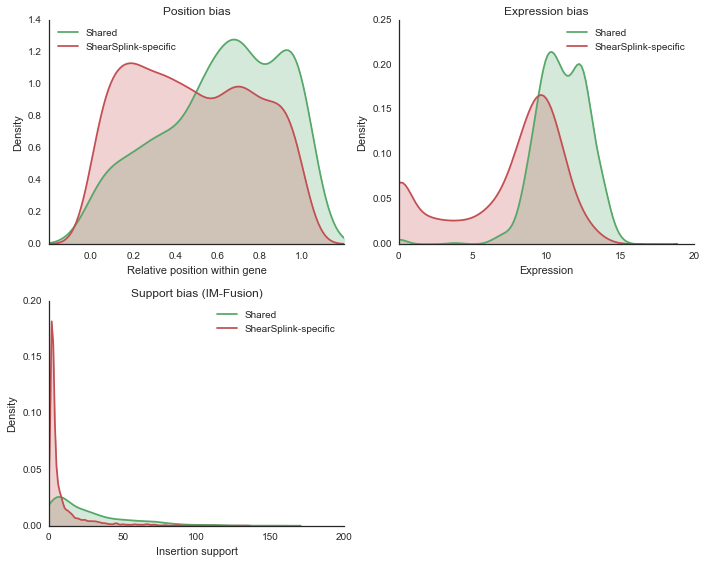

In [8]:
# Draw plots.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

match.plot_dna_position_bias(dna_matches, ax=axes[0, 0])
match.plot_expression_bias(dna_matches, ax=axes[0, 1])
match.plot_dna_depth_bias(dna_matches, ax=axes[1, 0])

plt.tight_layout()
axes[-1, -1].axis('off')

# Draw for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_dna_position_bias(dna_matches, ax=ax)
    #fig.savefig('../reports/figures/fig_4b_position_bias.pdf', bbox_inches='tight')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_expression_bias(dna_matches, ax=ax)
    ax.legend().remove()
    #fig.savefig('../reports/figures/fig_4c_expression_bias.pdf', bbox_inches='tight')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_dna_depth_bias(dna_matches, ax=ax)
    ax.legend().remove()
    #fig.savefig('../reports/figures/fig_4d_dna_depth_bias.pdf', bbox_inches='tight')
    plt.close(fig)

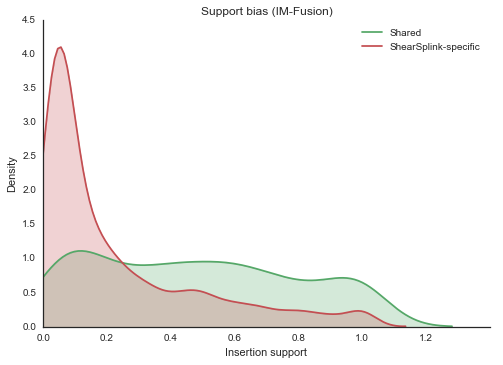

In [9]:
match.plot_dna_depth_bias(dna_matches, var='dna_clonality')

From this we can clearly see that insertions that occur in the beginning of the gene are more likely to be missed by IM-Fusion than insertions that occur closer to the end of the gene. Similarly, insertions in genes with low expression tend to be missed, as do genes with low ShearSplink support scores.

#### IM-Fusion-specific insertions

For the IM-Fusion-specific insertions we train a model using the IM-Fusion support (rna_support) as the main feature.

In [8]:
rna_matches = matches.ix[matches.type != 'ShearSplink-specific']

data = rna_matches[['rna_support', 'type']].copy()
data['type'] = data['type'].map({'Shared': 1, 'IM-Fusion-specific': 0})

model = logit('type ~ rna_support', data)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.543546
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   type   No. Observations:                  818
Model:                          Logit   Df Residuals:                      816
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Mar 2017   Pseudo R-squ.:                  0.1018
Time:                        11:42:37   Log-Likelihood:                -444.62
converged:                       True   LL-Null:                       -495.03
                                        LLR p-value:                 1.012e-23
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0588      0.132     -0.445      0.656      -0.318       0.200
rna_support     0.1769    

This shows that the support from IM-Fusion is significantly predictive of whether an insertion is matched. From the distribution of this feature, we see that insertions with lower support scores tend to be IM-Fusion-specific (similar to the results for the ShearSplink support score):

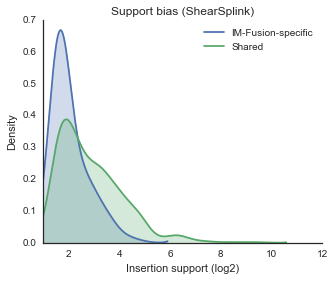

In [9]:
# Plot insertion depth.
fig, ax = plt.subplots(figsize=(5, 4))
match.plot_rna_depth_bias(rna_matches, ax=ax)

# Draw for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2, 1.5))
    match.plot_rna_depth_bias(rna_matches, ax=ax)
    fig.savefig('../reports/figures/fig_4e_rna_depth_bias.pdf', bbox_inches='tight')
    plt.close(fig)

## Comparing CTGs

### CTG ranking

To determine if IM-Fusion identifies different candidate genes than ShearSplink, we want to compare the DE CTGs from IM-Fusion to the genes associated with CISs from the ShearSplink analysis. 

To do so, we first read the CTG/CIS results of the IM-Fusion and ShearSplink analyses.

In [10]:
# Read RNA CTGs.
rna_ctgs = (pd.read_csv('../data/processed/sb/star/ctgs.txt', sep='\t')
              .sort_values(['n_samples'], ascending=False))

# Read DNA CTGs.
dna_hits = (pd.read_csv('../data/external/shear_splink/insertions.cis.rbm.txt', sep='\t')
              .groupby('gene_name')['sample'].nunique().reset_index()
              .sort_values('sample', ascending=False))

We then plot a comparison of the identified genes by plotting the gene rankings from both approaches:

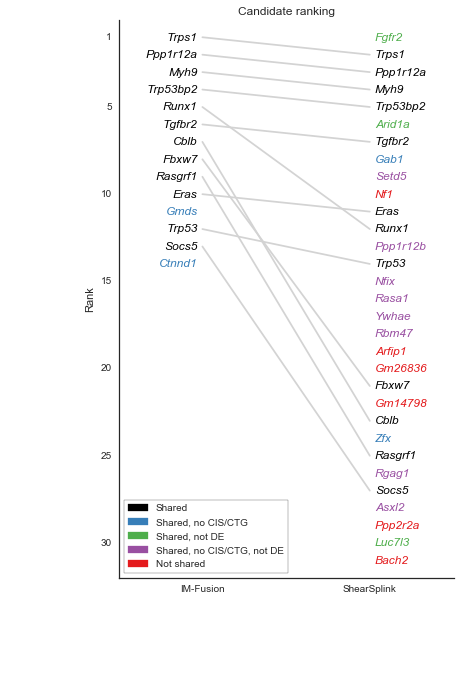

In [11]:
import toolz
from nbsupport import rank
from imfusion.expression import read_exon_counts
        
# Read counts and create gene_id --> gene_name map needed for annotate_de.
exon_counts = read_exon_counts('../data/processed/sb/star/expression.txt')

gene_id_map = toolz.merge(
     dict(zip(insertions_dna['gene_name'], insertions_dna['gene_id'])),
     dict(zip(insertions_rna['gene_name'], insertions_rna['gene_id'])))

# Compare and annotate rankings.
ranks = (
    rank.compare_ranks(rna_ctgs.query('de_pvalue < 0.05'), 
                       dna_hits, suffixes=('_rna', '_dna'))
        .pipe(rank.annotate_ctg, ctgs=rna_ctgs, col_name='ctg_rna')
        .pipe(rank.annotate_ctg, ctgs=dna_hits, col_name='ctg_dna')
        .pipe(rank.annotate_ins, insertions=insertions_rna, col_name='ins_rna')
        .pipe(rank.annotate_ins, insertions=insertions_dna, col_name='ins_dna')
        .pipe(rank.annotate_de, insertions=insertions_rna, 
              exon_counts=exon_counts, gene_id_map=gene_id_map,
              col_name='is_de', fallback_to_gene=True)
        .pipe(rank.annotate_type))
    
# Plot ranking.
order = rank.RANK_TYPES
palette = (['black'] + sns.color_palette('Set1')[1:4] + 
           [sns.color_palette('Set1')[0]])

fig, ax = plt.subplots(figsize=(6, 10)) 
rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                label='gene_name', hue='type', ax=ax,
                palette=palette, order=order,
                legend_kws={'frameon': True, 
                            'loc': 'lower left'},
                label_kws={'fontstyle': 'italic'})
ax.set_xticklabels(['IM-Fusion', 'ShearSplink']);
ax.set_title('Candidate ranking')

# Draw for manuscript:
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(2.4, 4.2)) 
    rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                    label='gene_name', hue='type', ax=ax,
                    palette=palette, order=order,
                    legend_kws={'frameon': False, 
                                'loc': 'lower left'},
                    label_kws={'fontstyle': 'italic'})
    ax.set_xlim(-0.9, 1.9)
    ax.set_xticklabels(['IM-Fusion', 'ShearSplink'])
    ax.set_title('Candidate ranking')

    fig.savefig('../reports/figures/fig_4f_ctg_ranks.pdf', bbox_inches='tight')
    plt.close(fig)

Here, grey lines indicate the relative rankings of genes that are identified by both approaches. Genes missed by the other approach are marked red. Genes that are identified to have insertions but are not selected as CTGs by the other approach are colored blue or purple, depending on their differential expression status. Genes that are identified as CISs/CTGs but are not differentially expressed are marked green.

### Fgfr2 insertions

Interestingly, from the above comparison we see that the top ShearSplink candidate is not selected by IM-Fusion due to lack of differential expression. To see why this might be the case, we first have a look at the types of insertions that we see in *Fgfr2*:

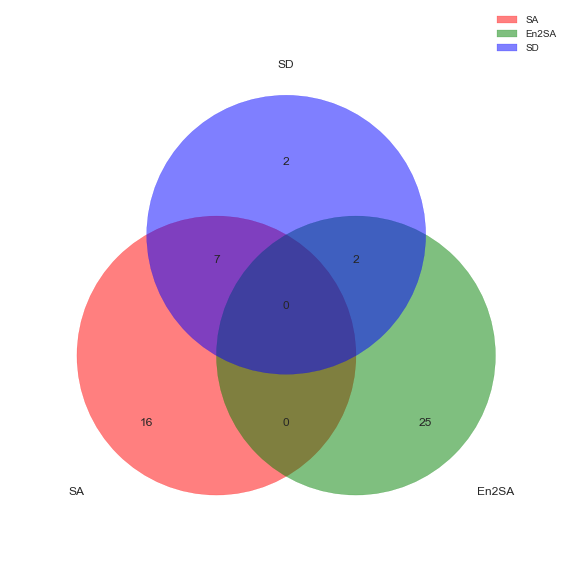

In [12]:
from nbsupport.venn import venn

fgfr2_grps = {key: set(grp['sample']) for key, grp in 
              (insertions_rna.query('gene_name == "Fgfr2"')
                             .groupby('feature_name'))}

venn(list(fgfr2_grps.values()), names=list(fgfr2_grps.keys()));


# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig = venn(list(fgfr2_grps.values()), 
               names=list(fgfr2_grps.keys()), figsize=(4, 2.8))
    fig.suptitle('Feature overlap', fontsize=7, y=0.9)
    fig.savefig('../reports/supplemental/figures/fig_s3b_fgfr2_venn.pdf', bbox_inches='tight')
    plt.close(fig)

This venn diagram shows that samples with SA insertions tend also tend to have an SD insertion. This suggests that these samples are affected by sense insertions, which result in the simultaenous truncation of the gene and over-expression of a C-terminal transcript. Antisense insertions (which use the En2SA site) cannot have this type of effect, as in these cases the SD site is in the wrong orientation to start a new transcript.

To determine if this is supported by the expression data, we can split samples into two groups (with sense/antisense insertions) and repeat the DE analysis:

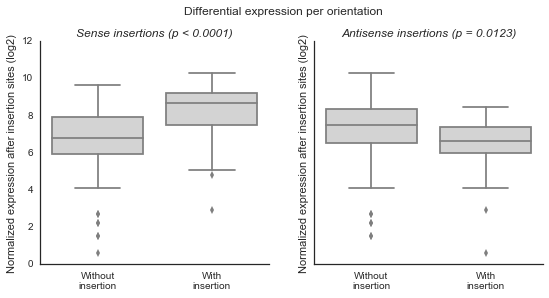

In [20]:
from imfusion.model import Insertion
from nbsupport import insertions as nb_ins

insertion_objs = list(Insertion.from_frame(insertions_rna))

# Determine sample sets.
sense_samples = set(insertions_rna.query(
    'gene_name == "Fgfr2" and orientation == "sense"')['sample'])

antisense_samples = set(insertions_rna.query(
    'gene_name == "Fgfr2" and orientation == "antisense"')['sample'])


# Plot stratified DE.
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
               gene_name='Fgfr2', pos_samples=sense_samples, ax=axes[0])
axes[0].set_title(axes[0].get_title().replace('Fgfr2', 'Sense insertions'))

nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
               gene_name='Fgfr2', pos_samples=antisense_samples, ax=axes[1])
axes[1].set_title(axes[1].get_title().replace('Fgfr2', 'Antisense insertions'))

sns.despine()

fig.suptitle('Differential expression per orientation', y=1.02)

# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plt.subplots(ncols=2, figsize=(4, 2), sharey=True)

    nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
                   gene_name='Fgfr2', pos_samples=sense_samples, ax=axes[0],
                   box_kws={'linewidth': 0.75, 'fliersize': 2})
    axes[0].set_title(axes[0].get_title().replace('Fgfr2', 'Sense insertions'))
    
    nb_ins.plot_de(insertion_objs, exon_counts, gene_id='ENSMUSG00000030849',
                   gene_name='Fgfr2', pos_samples=antisense_samples, 
                   ax=axes[1], box_kws={'linewidth': 0.75, 'fliersize': 2})
    axes[1].set_title(axes[1].get_title().replace('Fgfr2', 'Antisense insertions'))

    axes[1].set_ylabel('')
    
    sns.despine()

    fig.suptitle('Differential expression per orientation', y=1.04, fontsize=7)
    
    fig.savefig('../reports/supplemental/figures/fig_s3a_fgfr2_de.pdf', bbox_inches='tight')
    plt.close(fig)

This shows that antisense insertions generally show a decrease in expression after the insertion site, whilst sense insertions show an increase. This supports our hypothesis that antisense insertions merely truncate the gene, whilst sense insertions also result in the expression of a C-terminal transcript.